**Links**

[Kaggle Dataset](https://www.kaggle.com/datasets/andrewmvd/face-mask-detection?resource=download)

In [1]:
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [2]:
annotations_dir = os.path.abspath("data/annotations")
images_dir = os.path.abspath("data/images")

# Parse XML Data Annotations

In [3]:
import xmltodict

def insert_annotation_from_object(annotations, object, data_dict):
    ''' Set information from object and data_dict into annotations'''
    filename = data_dict["annotation"]["filename"]
    width = int(data_dict["annotation"]["size"]["width"])
    height = int(data_dict["annotation"]["size"]["height"])
    depth = int(data_dict["annotation"]["size"]["depth"])
    segmented = int(data_dict["annotation"]["segmented"])
    label = object["name"]
    pose = object["pose"]
    truncated = object["truncated"]
    occluded = object["occluded"]
    difficult = object["difficult"]
    xmin = int(object["bndbox"]["xmin"])
    ymin = int(object["bndbox"]["ymin"])
    xmax = int(object["bndbox"]["xmax"])
    ymax = int(object["bndbox"]["ymax"])

    annotations["filename"].append(filename)
    annotations["width"].append(width)
    annotations["height"].append(height)
    annotations["depth"].append(depth)
    annotations["segmented"].append(segmented)
    annotations["label"].append(label)
    annotations["pose"].append(pose)
    annotations["truncated"].append(truncated)
    annotations["occluded"].append(occluded)
    annotations["difficult"].append(difficult)
    annotations["xmin"].append(xmin)
    annotations["ymin"].append(ymin)
    annotations["xmax"].append(xmax)
    annotations["ymax"].append(ymax)


def get_all_annotations_from_xml(annotations_dir):
    annotations = {
        "filename": [],
        "label": [], 
        "pose": [],
        "truncated": [],
        "occluded": [],
        "difficult": [],
        "xmin": [], 
        "ymin": [], 
        "xmax": [], 
        "ymax": [], 
        "width": [], 
        "height": [],
        "depth": [],
        "segmented": []
    }

    for file in os.listdir(annotations_dir):
        with open(annotations_dir + "/" + file) as xml_file:
            data_dict = xmltodict.parse(xml_file.read())
            xml_file.close()

            object = data_dict["annotation"]["object"]
            # If there is only one instance of a mask in the XML file, the object will return as a dictionary
            if isinstance(object, dict):
                insert_annotation_from_object(annotations, object, data_dict)
                pass

            # If there are multiple instances of a masks in the XML file, the object will return as a list
            elif isinstance(object, list):
                for obj in object:
                    insert_annotation_from_object(annotations, obj, data_dict)


    return pd.DataFrame.from_dict(annotations)

In [4]:
annotations = get_all_annotations_from_xml(annotations_dir)

# EDA

- Histogram of labels
- Sample of 5 images
- Size of cropped images

### Number of images and masks

In [5]:
# Number of pictures
print("Number of images: " + str(len(annotations["filename"].unique())))

Number of images: 853


In [6]:
# Number of masks
print("Number of masks: " + str(len(annotations)))

Number of masks: 4072


### Histogram of labels

Text(0.5, 1.0, 'Histogram of Labels')

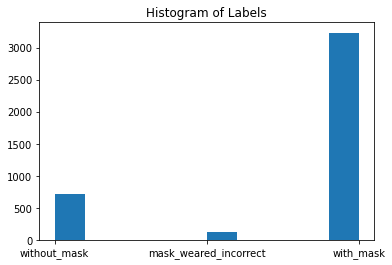

In [7]:
# Histogram of labels
plt.hist(annotations["label"])
plt.title("Histogram of Labels")

### Image Preview 

In [8]:
images = {}

for idx, img_name in enumerate(os.listdir(images_dir)):
    img = load_img(images_dir + "/" + img_name)
    images[img_name] = img

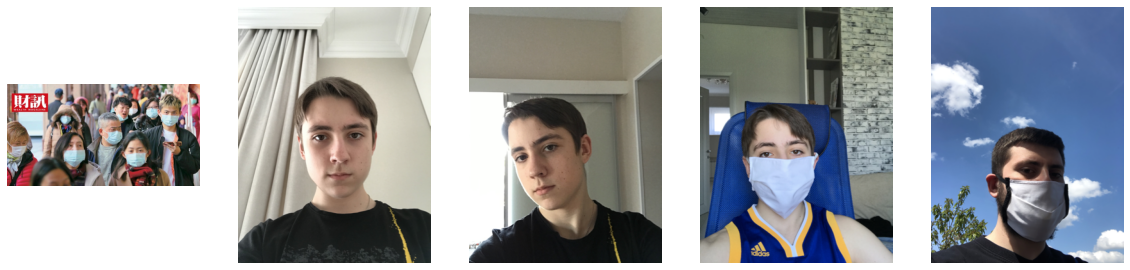

In [9]:
nrows, ncols = 1, 5

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,10))
for i in range(ncols):
    axs[i].imshow(list(images.values())[i])
    axs[i].axis('off')

### Scatterplot of cropped image dimensions

In [10]:
annotations["crop_width"] = annotations["xmax"] - annotations["xmin"]
annotations["crop_height"] = annotations["ymax"] - annotations["ymin"]

Text(0.5, 1.0, 'Scatterplot of cropped images dimensions')

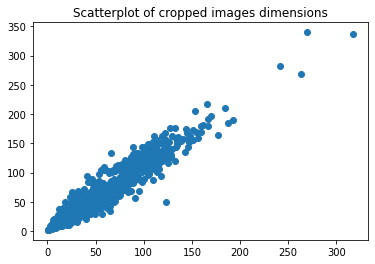

In [11]:
plt.scatter(x=annotations["crop_width"], y=annotations["crop_height"])
plt.title("Scatterplot of cropped images dimensions")

# Feature Engineering

### Remove "mask_weared_incorrect"

Number of masks:  3949


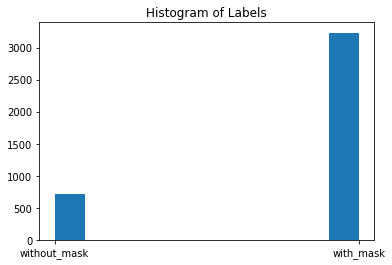

In [24]:
annotations = annotations.drop(annotations[annotations["label"] == "mask_weared_incorrect"].index).reset_index(drop=True)

plt.hist(annotations["label"])
plt.title("Histogram of Labels")

print("Number of masks: ", len(annotations))

### Remove mask images that are too small

In [25]:
annotations = annotations[(annotations["crop_width"] >= 10) & (annotations["crop_height"] >= 10)]

print("Number of masks: ", len(annotations))

Number of masks:  3485


### Get equal number of images with masks and without masks

In [32]:
without_mask_count = len(annotations[annotations["label"] == "without_mask"])
with_mask_count = len(annotations[annotations["label"] == "with_mask"])
drop_count = with_mask_count - without_mask_count

annotations = annotations.drop(annotations[annotations["label"] == "with_mask"].sample(drop_count).index).reset_index(drop=True)
print("Number of rmasks: ", len(annotations))

Number of rmasks:  1216


### Create normalization column
Tensorflow needs the x-y coordinates to be normalized in [0,1] interval in order to crop

In [33]:
annotations["xmin_normal"] = annotations["xmin"] / annotations["width"]
annotations["xmax_normal"] = annotations["xmax"] / annotations["width"]
annotations["ymin_normal"] = annotations["ymin"] / annotations["height"]
annotations["ymax_normal"] = annotations["ymax"] / annotations["height"]

annotations[["xmin_normal", "xmax_normal", "ymin_normal", "ymax_normal"]]

,xmin_normal,xmax_normal,ymin_normal,ymax_normal
0,0.205980,0.531561,0.485000,0.800000
1,0.142857,0.495017,0.422500,0.770000
2,0.400000,0.440000,0.247191,0.310861
3,0.592500,0.620000,0.153558,0.217228
4,0.375415,0.717608,0.575000,0.920000
...,...,...,...,...
1211,0.060000,0.152500,0.086142,0.209738
1212,0.235000,0.277500,0.254682,0.314607
1213,0.597500,0.642500,0.232210,0.303371
1214,0.617500,0.642500,0.007491,0.044944


### Crop Images

In [34]:
def get_cropped_images(img_filename, bounding_box):
    # Convert image to 4D Tensor shape [batch_size, image_height, image_width, depth]
    tf_img = tf.convert_to_tensor([img_to_array(images[img_filename])/256], dtype=tf.float32)

    # Get the bounded boxes of each mask
    boxes = tf.constant(bounding_box, dtype=tf.float32)

    # Set all mask indices to 0 since there's only one image
    box_indices = tf.constant(shape=(len(boxes),), value=0, dtype=tf.int32)

    # size of cropped image
    crop_size = (100, 100)

    # Crop and resize image
    return tf.image.crop_and_resize(tf_img, boxes, box_indices, crop_size)

### Run function and save images

In [43]:
import shutil

REPLACE_CROP_DIR = True

crop_img_dir = os.path.abspath("data/crop")

# If directory exists, replace
if REPLACE_CROP_DIR:
    if os.path.isdir(crop_img_dir):
        shutil.rmtree(crop_img_dir)
    os.mkdir(crop_img_dir)

# Save image and filepath to annotations dataframe
for i in range(len(annotations)):
    a = annotations.loc[i]
    img_filename = a["filename"]
    bounding_box = [a[["ymin_normal", "xmin_normal", "ymax_normal", "xmax_normal"]]]
    cropped_imgs = get_cropped_images(img_filename, bounding_box)[0]
    crop_img_filename = "crop" + str(i) + ".png"
    if REPLACE_CROP_DIR:
        tf.keras.utils.save_img(crop_img_dir + "/" + crop_img_filename , cropped_imgs)
    annotations.loc[i, "crop_img_filename"] = crop_img_filename


### Display sample of cropped images

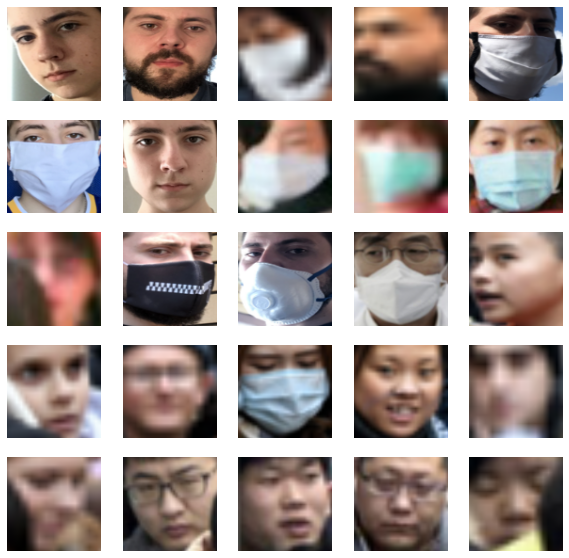

In [44]:
nrows, ncols = 5, 5

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,10))
for i in range(nrows):
    for j in range(ncols):
        img_loc = crop_img_dir + "/" + annotations.loc[i * nrows + j]["crop_img_filename"]
        axs[i, j].imshow(load_img(img_loc))
        axs[i, j].axis('off')